In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# test pytorch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
df = pd.read_csv("../data/camelyon17_v1.0/metadata.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455954 entries, 0 to 455953
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Unnamed: 0  455954 non-null  int64
 1   patient     455954 non-null  int64
 2   node        455954 non-null  int64
 3   x_coord     455954 non-null  int64
 4   y_coord     455954 non-null  int64
 5   tumor       455954 non-null  int64
 6   slide       455954 non-null  int64
 7   center      455954 non-null  int64
 8   split       455954 non-null  int64
dtypes: int64(9)
memory usage: 31.3 MB


In [4]:
def make_path(row):
    p = f"{row.patient:03d}"
    return (
        f"../data/camelyon17_v1.0/patches/"
        f"patient_{p}_node_{row.node}/"
        f"patch_patient_{p}_node_{row.node}_x_{row.x_coord}_y_{row.y_coord}.png"
    )

df["img_path"] = df.apply(make_path, axis=1)
df.head()

,Unnamed: 0,patient,node,x_coord,y_coord,tumor,slide,center,split,img_path
0,0,4,4,3328,21792,1,0,0,0,../data/camelyon17_v1.0/patches/patient_004_no...
1,1,4,4,3200,22272,1,0,0,0,../data/camelyon17_v1.0/patches/patient_004_no...
2,2,4,4,3168,22272,1,0,0,0,../data/camelyon17_v1.0/patches/patient_004_no...
3,3,4,4,3328,21760,1,0,0,0,../data/camelyon17_v1.0/patches/patient_004_no...
4,4,4,4,3232,22240,1,0,0,0,../data/camelyon17_v1.0/patches/patient_004_no...


In [5]:
cat_cols = ["patient", "node", "slide", "center"]
cont_cols = ["x_coord", "y_coord"]

# Create label encoders for categorical columns to map to 0-indexed consecutive integers
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[f"{col}_encoded"] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"{col}: {df[col].nunique()} unique values -> encoded to 0-{len(le.classes_)-1}")

# Update to use encoded columns
cat_cols_encoded = [f"{col}_encoded" for col in cat_cols]

# IMPORTANT: Recreate train/val splits AFTER encoding
train_df = df[df["split"] == 0].copy()
val_df = df[df["split"] == 1].copy()

print("\nTrain set size:", len(train_df))
print("Validation set size:", len(val_df))

scaler = StandardScaler()
train_cont = scaler.fit_transform(train_df[cont_cols])
val_cont = scaler.transform(val_df[cont_cols])

patient: 43 unique values -> encoded to 0-42
node: 5 unique values -> encoded to 0-4
slide: 50 unique values -> encoded to 0-49
center: 5 unique values -> encoded to 0-4

Train set size: 410359
Validation set size: 45595


In [6]:
class CamelyonDataset(Dataset):
    def __init__(self, df, cont_array, transform=None):
        self.df = df.reset_index(drop=True)
        self.cont = cont_array.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row.img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # Use encoded categorical columns
        cat = torch.tensor([int(row[col]) for col in cat_cols_encoded], dtype=torch.long)
        cont = torch.tensor(self.cont[idx], dtype=torch.float32)
        y = torch.tensor(row.tumor, dtype=torch.float32)
        return img, cat, cont, y

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds = CamelyonDataset(train_df, train_cont, transform=transform)
val_ds = CamelyonDataset(val_df, val_cont, transform=transform)

# On Windows, num_workers must be 0 to avoid multiprocessing issues in notebooks
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)

In [8]:
class MultiModalModel(nn.Module):
    def __init__(self, cat_sizes, cont_dim, emb_dim=8, hidden=128):
        super().__init__()
        # CNN
        self.cnn = models.resnet18(weights=None)
        self.cnn.fc = nn.Identity()
        cnn_out = 512

        # Embeddings categoriels
        self.embeddings = nn.ModuleList([
            nn.Embedding(size, emb_dim) for size in cat_sizes
        ])
        emb_out = emb_dim * len(cat_sizes)

        # MLP meta
        self.meta_mlp = nn.Sequential(
            nn.Linear(emb_out + cont_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        # Tete finale
        self.classifier = nn.Sequential(
            nn.Linear(cnn_out + hidden, 1)
        )

    def forward(self, img, cat, cont):
        img_feat = self.cnn(img)
        emb_list = [emb(cat[:, i]) for i, emb in enumerate(self.embeddings)]
        meta = torch.cat(emb_list + [cont], dim=1)
        meta_feat = self.meta_mlp(meta)
        fused = torch.cat([img_feat, meta_feat], dim=1)
        logits = self.classifier(fused).squeeze(1)
        return logits


In [9]:
cat_sizes = [df[c].nunique() for c in cat_cols_encoded]
print("Embedding sizes:", cat_sizes)

model = MultiModalModel(cat_sizes, cont_dim=len(cont_cols)).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Embedding sizes: [43, 5, 50, 5]


In [10]:
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    mode = "Train" if train else "Val"
    pbar = tqdm(loader, desc=f"{mode}", leave=True)

    for imgs, cats, conts, y in pbar:
        imgs, cats, conts, y = imgs.to(device), cats.to(device), conts.to(device), y.to(device)
        logits = model(imgs, cats, conts)
        loss = criterion(logits, y)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * y.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)

        # Update progress bar with current metrics
        pbar.set_postfix({
            'loss': f'{total_loss/total:.4f}',
            'acc': f'{correct/total:.4f}'
        })

    return total_loss / total, correct / total

In [11]:
# LOAD THE MODEL
model = MultiModalModel(cat_sizes, cont_dim=len(cont_cols)).to(device)
model.load_state_dict(torch.load("multimodal_camelyon_model.pth"))
model.eval()

MultiModalModel(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [12]:
# Test et analyse du modèle afin de déterminer les taux de faux négatifs et faux positifs
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, cats, conts, y in tqdm(val_loader, desc="Testing", leave=True):
        imgs, cats, conts = imgs.to(device), cats.to(device), conts.to(device)
        logits = model(imgs, cats, conts)
        preds = (torch.sigmoid(logits) > 0.5).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


Testing: 100%|██████████| 713/713 [05:53<00:00,  2.02it/s]


In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()
print("Confusion Matrix:")
print(cm)
print(f"False Positives: {fp}, False Negatives: {fn}")

# tests complémentaires: Recall, Précision, F-Beta score
from sklearn.metrics import precision_score, recall_score, fbeta_score
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f2 = fbeta_score(all_labels, all_preds, beta=2)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F2 Score: {f2:.4f}")

# Coefficient de corrélation de Matthews MCC
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(all_labels, all_preds)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# score kappa de Cohen
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Cohen's Kappa Score: {kappa:.4f}")

# AUC-PR and AUC-ROC
from sklearn.metrics import roc_auc_score, average_precision_score
roc_auc = roc_auc_score(all_labels, all_preds)
pr_auc = average_precision_score(all_labels, all_preds)
print(f"AUC-ROC: {roc_auc:.4f}, AUC-PR: {pr_auc:.4f}")

Confusion Matrix:
[[22731   215]
 [  322 22327]]
False Positives: 215, False Negatives: 322
Precision: 0.9905, Recall: 0.9858, F2 Score: 0.9867
Matthews Correlation Coefficient (MCC): 0.9765
Cohen's Kappa Score: 0.9764
AUC-ROC: 0.9882, AUC-PR: 0.9834


Calibration: 100%|██████████| 713/713 [01:20<00:00,  8.87it/s]


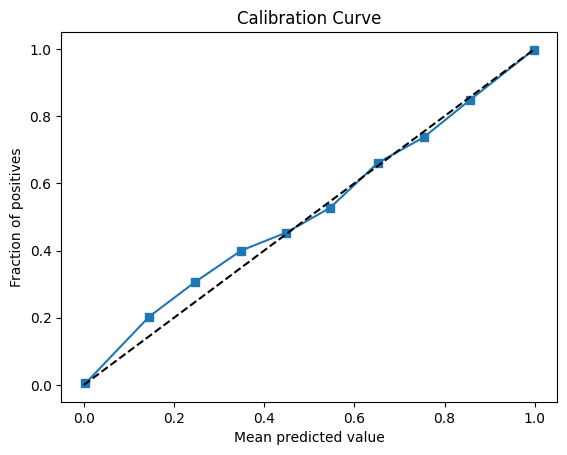

In [14]:
# Erreur de Calibration (Expected Calibration Error - ECE)
from sklearn.calibration import calibration_curve
prob_preds = []
with torch.no_grad():
    for imgs, cats, conts, y in tqdm(val_loader, desc="Calibration", leave=True):
        imgs, cats, conts = imgs.to(device), cats.to(device), conts.to(device)
        logits = model(imgs, cats, conts)
        probs = torch.sigmoid(logits).cpu().numpy()
        prob_preds.extend(probs)
prob_preds = np.array(prob_preds)
fraction_of_positives, mean_predicted_value = calibration_curve(all_labels, prob_preds, n_bins=10)
import matplotlib.pyplot as plt
plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.show()

t:\taf\Data\projet-spe2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:01<00:00, 644.42it/s]


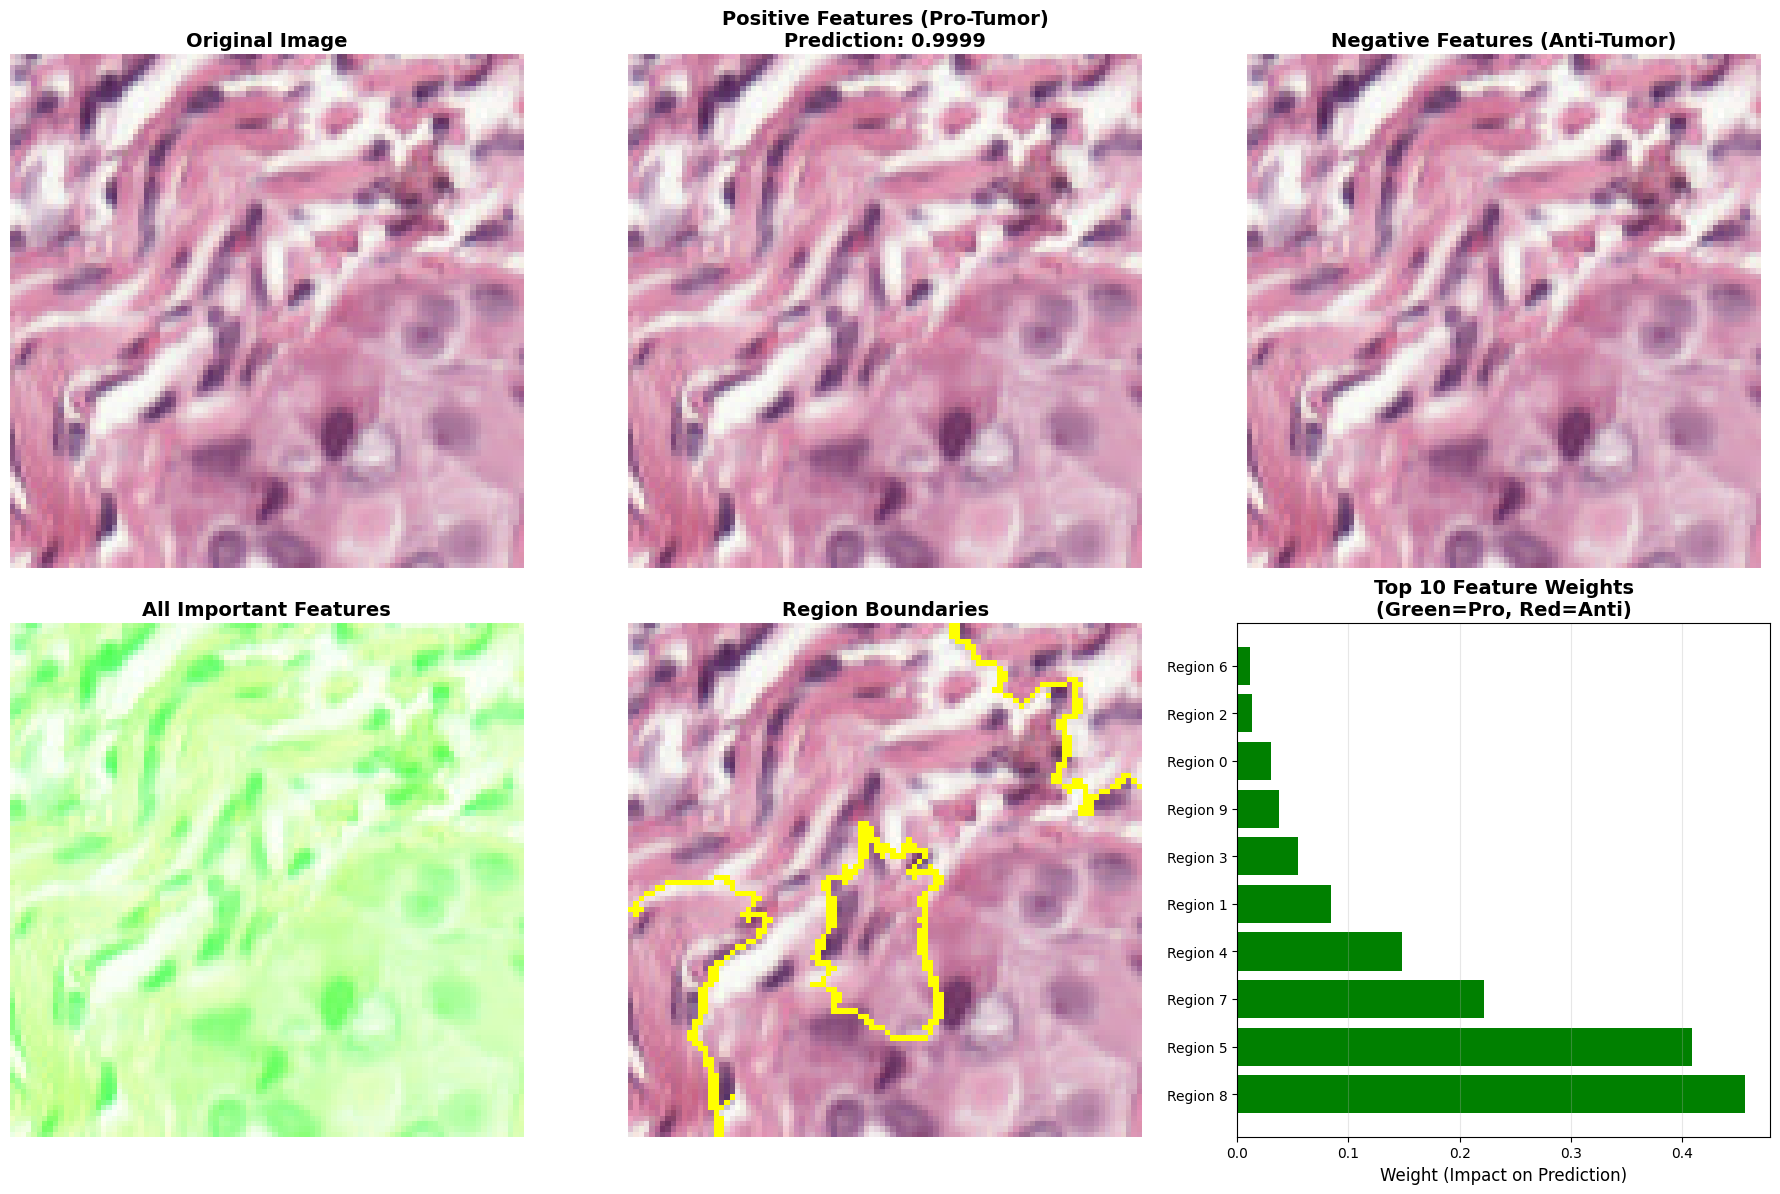


PREDICTION DETAILS
Predicted probability of tumor: 0.999856
Predicted class: TUMOR
Confidence: 99.97%

Top 10 contributing regions:
  1. Region 8: +0.4561 (PRO-tumor)
  2. Region 5: +0.4083 (PRO-tumor)
  3. Region 7: +0.2216 (PRO-tumor)
  4. Region 4: +0.1483 (PRO-tumor)
  5. Region 1: +0.0842 (PRO-tumor)
  6. Region 3: +0.0544 (PRO-tumor)
  7. Region 9: +0.0380 (PRO-tumor)
  8. Region 0: +0.0308 (PRO-tumor)
  9. Region 2: +0.0135 (PRO-tumor)
  10. Region 6: +0.0112 (PRO-tumor)



0.9998562335968018

In [15]:
# make a LIME explainer for image data
from lime import lime_image
from skimage.segmentation import mark_boundaries
explainer = lime_image.LimeImageExplainer()

def explain_instance(img_path, cat, cont):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    cat_tensor = torch.tensor(cat, dtype=torch.long).unsqueeze(0).to(device)
    cont_tensor = torch.tensor(cont, dtype=torch.float32).unsqueeze(0).to(device)

    def batch_predict(images):
        model.eval()
        batch = torch.stack([transform(Image.fromarray(img)).to(device) for img in images], dim=0)
        with torch.no_grad():
            logits = model(batch, cat_tensor.repeat(len(images), 1), cont_tensor.repeat(len(images), 1))
            probs = torch.sigmoid(logits).cpu().numpy()
        return np.vstack([1 - probs, probs]).T

    # Generate explanation
    explanation = explainer.explain_instance(
        np.array(img),
        batch_predict,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )

    # Get prediction
    with torch.no_grad():
        logits = model(img_tensor, cat_tensor, cont_tensor)
        prob = torch.sigmoid(logits).item()

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Original image
    axes[0, 0].imshow(np.array(img))
    axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')

    # 2. Positive features only (supporting tumor prediction)
    temp_pos, mask_pos = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=False
    )
    axes[0, 1].imshow(temp_pos)
    axes[0, 1].set_title(f'Positive Features (Pro-Tumor)\nPrediction: {prob:.4f}',
                         fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')

    # 3. Negative features only (contradicting tumor prediction)
    temp_neg, mask_neg = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        negative_only=True,
        num_features=10,
        hide_rest=False
    )
    axes[0, 2].imshow(temp_neg)
    axes[0, 2].set_title('Negative Features (Anti-Tumor)', fontsize=14, fontweight='bold')
    axes[0, 2].axis('off')

    # 4. Heatmap overlay
    from matplotlib import cm
    temp_all, mask_all = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=10,
        hide_rest=False
    )
    axes[1, 0].imshow(temp_all)
    axes[1, 0].set_title('All Important Features', fontsize=14, fontweight='bold')
    axes[1, 0].axis('off')

    # 5. Segmentation boundaries
    temp_boundary, mask_boundary = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    boundary_img = mark_boundaries(temp_boundary / 255.0, mask_boundary)
    axes[1, 1].imshow(boundary_img)
    axes[1, 1].set_title('Region Boundaries', fontsize=14, fontweight='bold')
    axes[1, 1].axis('off')

    # 6. Feature importance weights
    local_exp = explanation.local_exp[explanation.top_labels[0]]
    features, weights = zip(*local_exp[:10])  # Top 10 features
    colors = ['green' if w > 0 else 'red' for w in weights]
    axes[1, 2].barh(range(len(weights)), weights, color=colors)
    axes[1, 2].set_yticks(range(len(weights)))
    axes[1, 2].set_yticklabels([f'Region {f}' for f in features])
    axes[1, 2].set_xlabel('Weight (Impact on Prediction)', fontsize=12)
    axes[1, 2].set_title('Top 10 Feature Weights\n(Green=Pro, Red=Anti)',
                         fontsize=14, fontweight='bold')
    axes[1, 2].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed prediction info
    print(f"\n{'='*60}")
    print(f"PREDICTION DETAILS")
    print(f"{'='*60}")
    print(f"Predicted probability of tumor: {prob:.6f}")
    print(f"Predicted class: {'TUMOR' if prob > 0.5 else 'NO TUMOR'}")
    print(f"Confidence: {abs(prob - 0.5) * 200:.2f}%")
    print(f"\nTop 10 contributing regions:")
    for i, (feature, weight) in enumerate(local_exp[:10], 1):
        direction = "PRO-tumor" if weight > 0 else "ANTI-tumor"
        print(f"  {i}. Region {feature}: {weight:+.4f} ({direction})")
    print(f"{'='*60}\n")

    return prob

# use LIME explainer for a sample from validation set, visualize the explanation, and print the prediction
sample_idx = 1
sample_row = val_df.iloc[sample_idx]
explain_instance(
    sample_row.img_path,
    [int(sample_row[col]) for col in cat_cols_encoded],
    val_cont[sample_idx]
)

Creating SHAP explainer with background samples...
SHAP explainer ready!

Computing SHAP values (this may take a moment)...


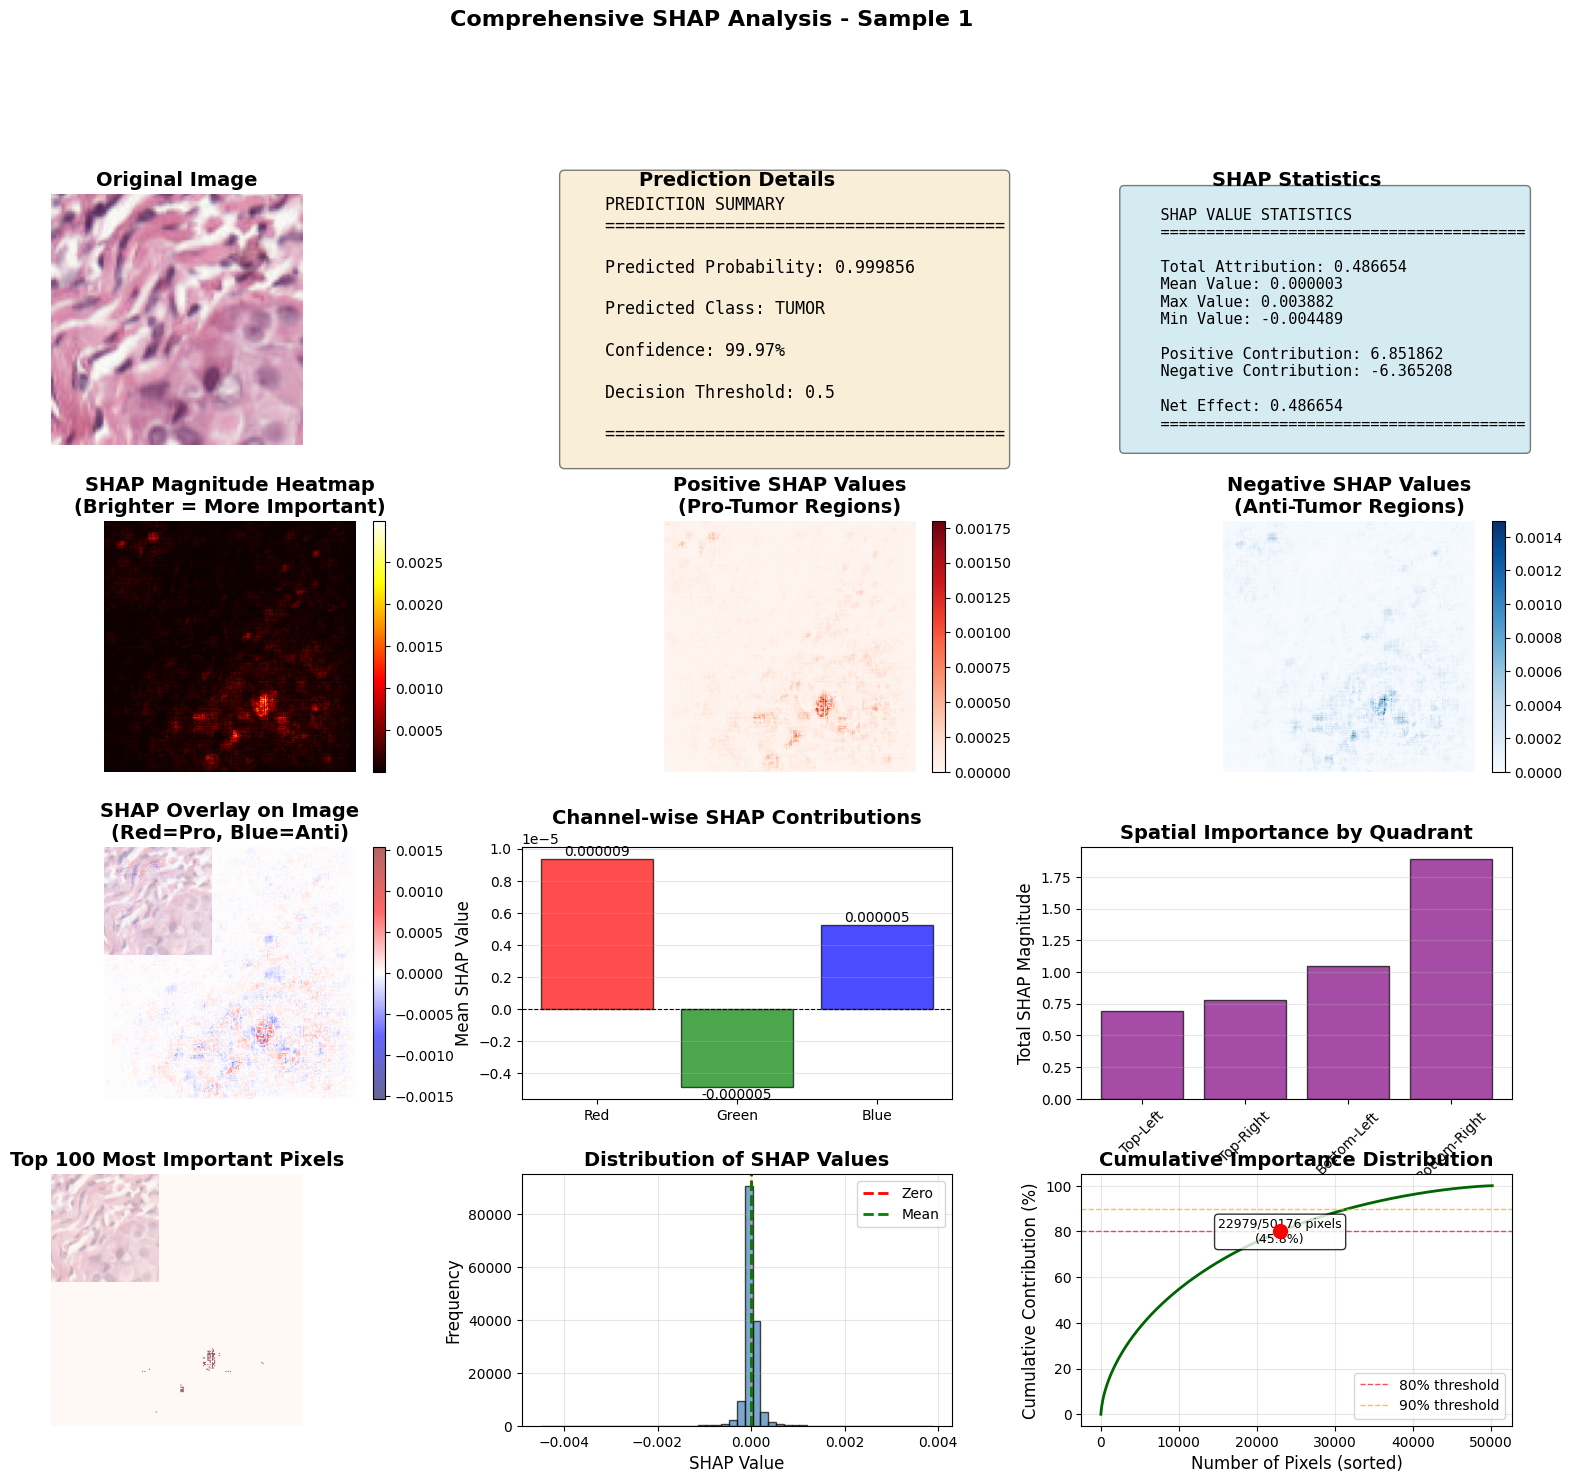


DETAILED SHAP ANALYSIS REPORT

1. PREDICTION METRICS:
   - Probability: 0.999856
   - Class: TUMOR (1)
   - Confidence: 99.97%

2. SHAP VALUE ANALYSIS:
   - Total Attribution: 0.486654
   - Mean Attribution: 0.000003
   - Range: [-0.004489, 0.003882]
   - Standard Deviation: 0.000167

3. CONTRIBUTION BREAKDOWN:
   - Positive (Pro-Tumor): 6.851862 (51.8%)
   - Negative (Anti-Tumor): -6.365208 (48.2%)
   - Net Effect: 0.486654

4. SPATIAL ANALYSIS:
   - Top-Left: 0.691669 (15.7%)
   - Top-Right: 0.776498 (17.6%)
   - Bottom-Left: 1.050224 (23.8%)
   - Bottom-Right: 1.887299 (42.8%)

5. CHANNEL CONTRIBUTIONS:
   - Red Channel: 0.000009
   - Green Channel: -0.000005
   - Blue Channel: 0.000005

6. PIXEL IMPORTANCE:
   - 80% of importance comes from 22979/50176 pixels (45.8%)
   - This shows moderate localization




In [16]:
# make a SHAP explainer for image data
import shap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create a wrapper function for SHAP that handles the multimodal model
def create_shap_explainer():
    """Create SHAP Gradient Explainer for the multimodal model"""

    # Get a few background samples for SHAP
    background_indices = np.random.choice(len(val_df), size=20, replace=False)
    background_images = []
    background_cats = []
    background_conts = []

    for idx in background_indices:
        sample_row = val_df.iloc[idx]
        img = Image.open(sample_row.img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)
        cat_tensor = torch.tensor([int(sample_row[col]) for col in cat_cols_encoded], dtype=torch.long).unsqueeze(0).to(device)
        cont_tensor = torch.tensor(val_cont[idx], dtype=torch.float32).unsqueeze(0).to(device)

        background_images.append(img_tensor)
        background_cats.append(cat_tensor)
        background_conts.append(cont_tensor)

    background_images = torch.cat(background_images, dim=0)
    background_cats = torch.cat(background_cats, dim=0)
    background_conts = torch.cat(background_conts, dim=0)

    # Create model wrapper for SHAP
    class ModelWrapper(nn.Module):
        def __init__(self, model, cat_data, cont_data):
            super().__init__()
            self.model = model
            self.cat_data = cat_data
            self.cont_data = cont_data

        def forward(self, x):
            # Repeat cat and cont data to match batch size
            batch_size = x.shape[0]
            cats = self.cat_data[:batch_size]
            conts = self.cont_data[:batch_size]

            # Handle case where batch_size > available data
            if batch_size > len(self.cat_data):
                repeats = (batch_size + len(self.cat_data) - 1) // len(self.cat_data)
                cats = self.cat_data.repeat(repeats, 1)[:batch_size]
                conts = self.cont_data.repeat(repeats, 1)[:batch_size]

            logits = self.model(x, cats, conts)
            # SHAP expects 2D output: (batch_size, num_outputs)
            return torch.sigmoid(logits).unsqueeze(1)

    wrapped_model = ModelWrapper(model, background_cats, background_conts)
    explainer = shap.GradientExplainer(wrapped_model, background_images)

    return explainer, wrapped_model, background_cats, background_conts

def explain_with_shap(img_path, cat, cont, explainer, wrapped_model, bg_cats, bg_conts):
    """Generate comprehensive SHAP explanations for an image"""

    # Load and prepare image
    img = Image.open(img_path).convert("RGB")
    img_array = np.array(img)
    img_tensor = transform(img).unsqueeze(0).to(device)
    cat_tensor = torch.tensor(cat, dtype=torch.long).unsqueeze(0).to(device)
    cont_tensor = torch.tensor(cont, dtype=torch.float32).unsqueeze(0).to(device)

    # Get model prediction
    with torch.no_grad():
        logits = model(img_tensor, cat_tensor, cont_tensor)
        prob = torch.sigmoid(logits).item()

    # Update wrapper's metadata for this specific sample
    wrapped_model.cat_data = cat_tensor
    wrapped_model.cont_data = cont_tensor

    # Calculate SHAP values
    print("Computing SHAP values (this may take a moment)...")
    shap_values = explainer.shap_values(img_tensor)

    # Convert to numpy and handle dimensions
    # SHAP returns list of arrays for each output class
    if isinstance(shap_values, list):
        # We only have one output, so take the first (and only) element
        shap_values_np = shap_values[0]
    else:
        shap_values_np = shap_values

    # Convert to numpy if it's a tensor
    if torch.is_tensor(shap_values_np):
        shap_values_np = shap_values_np.cpu().numpy()

    # Remove any singleton dimensions first
    shap_values_np = np.squeeze(shap_values_np)

    # Now we should have either (C, H, W) or (H, W, C)
    # If we have 3 dimensions, assume (C, H, W) and transpose to (H, W, C)
    if shap_values_np.ndim == 3:
        # Check if it looks like (C, H, W) - channels should be 3 or 1
        if shap_values_np.shape[0] in [1, 3, 4]:
            shap_values_np = np.transpose(shap_values_np, (1, 2, 0))
    elif shap_values_np.ndim == 4:
        # If still 4D after squeeze, take first element and transpose
        shap_values_np = shap_values_np[0]
        if shap_values_np.shape[0] in [1, 3, 4]:
            shap_values_np = np.transpose(shap_values_np, (1, 2, 0))

    # Get the processed image
    img_processed = img_tensor[0].cpu().numpy()
    img_processed = np.transpose(img_processed, (1, 2, 0))

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

    # 1. Original Image
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img_array)
    ax1.set_title('Original Image', fontsize=14, fontweight='bold')
    ax1.axis('off')

    # 2. Model Prediction Info
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.axis('off')
    prediction_text = f"""
    PREDICTION SUMMARY
    {'='*40}

    Predicted Probability: {prob:.6f}

    Predicted Class: {'TUMOR' if prob > 0.5 else 'NO TUMOR'}

    Confidence: {abs(prob - 0.5) * 200:.2f}%

    Decision Threshold: 0.5

    {'='*40}
    """
    ax2.text(0.1, 0.5, prediction_text, fontsize=12, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax2.set_title('Prediction Details', fontsize=14, fontweight='bold')

    # 3. SHAP Statistics
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.axis('off')
    shap_sum = np.sum(shap_values_np)
    shap_mean = np.mean(shap_values_np)
    shap_max = np.max(shap_values_np)
    shap_min = np.min(shap_values_np)
    positive_contrib = np.sum(shap_values_np[shap_values_np > 0])
    negative_contrib = np.sum(shap_values_np[shap_values_np < 0])

    stats_text = f"""
    SHAP VALUE STATISTICS
    {'='*40}

    Total Attribution: {shap_sum:.6f}
    Mean Value: {shap_mean:.6f}
    Max Value: {shap_max:.6f}
    Min Value: {shap_min:.6f}

    Positive Contribution: {positive_contrib:.6f}
    Negative Contribution: {negative_contrib:.6f}

    Net Effect: {positive_contrib + negative_contrib:.6f}
    {'='*40}
    """
    ax3.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    ax3.set_title('SHAP Statistics', fontsize=14, fontweight='bold')

    # 4. SHAP Heatmap (Red-Blue)
    ax4 = fig.add_subplot(gs[1, 0])
    shap_rgb = np.mean(np.abs(shap_values_np), axis=2)
    im4 = ax4.imshow(shap_rgb, cmap='hot')
    ax4.set_title('SHAP Magnitude Heatmap\n(Brighter = More Important)', fontsize=14, fontweight='bold')
    ax4.axis('off')
    plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)

    # 5. SHAP Positive Contributions (Red)
    ax5 = fig.add_subplot(gs[1, 1])
    shap_positive = np.maximum(shap_values_np, 0)
    shap_positive_rgb = np.mean(shap_positive, axis=2)
    im5 = ax5.imshow(shap_positive_rgb, cmap='Reds')
    ax5.set_title('Positive SHAP Values\n(Pro-Tumor Regions)', fontsize=14, fontweight='bold')
    ax5.axis('off')
    plt.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)

    # 6. SHAP Negative Contributions (Blue)
    ax6 = fig.add_subplot(gs[1, 2])
    shap_negative = np.minimum(shap_values_np, 0)
    shap_negative_rgb = np.mean(np.abs(shap_negative), axis=2)
    im6 = ax6.imshow(shap_negative_rgb, cmap='Blues')
    ax6.set_title('Negative SHAP Values\n(Anti-Tumor Regions)', fontsize=14, fontweight='bold')
    ax6.axis('off')
    plt.colorbar(im6, ax=ax6, fraction=0.046, pad=0.04)

    # 7. SHAP Overlay on Original Image
    ax7 = fig.add_subplot(gs[2, 0])
    shap_overlay = np.mean(shap_values_np, axis=2)
    ax7.imshow(img_array)
    im7 = ax7.imshow(shap_overlay, cmap='seismic', alpha=0.6, vmin=-np.max(np.abs(shap_overlay)),
                     vmax=np.max(np.abs(shap_overlay)))
    ax7.set_title('SHAP Overlay on Image\n(Red=Pro, Blue=Anti)', fontsize=14, fontweight='bold')
    ax7.axis('off')
    plt.colorbar(im7, ax=ax7, fraction=0.046, pad=0.04)

    # 8. Per-Channel SHAP Analysis (RGB)
    ax8 = fig.add_subplot(gs[2, 1])
    channel_means = [np.mean(shap_values_np[:,:,i]) for i in range(3)]
    channel_names = ['Red', 'Green', 'Blue']
    colors_bar = ['red', 'green', 'blue']
    bars = ax8.bar(channel_names, channel_means, color=colors_bar, alpha=0.7, edgecolor='black')
    ax8.set_ylabel('Mean SHAP Value', fontsize=12)
    ax8.set_title('Channel-wise SHAP Contributions', fontsize=14, fontweight='bold')
    ax8.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    ax8.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.6f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

    # 9. Spatial Distribution
    ax9 = fig.add_subplot(gs[2, 2])
    shap_spatial = np.mean(np.abs(shap_values_np), axis=2)
    # Compute quadrant contributions
    h, w = shap_spatial.shape
    quadrants = {
        'Top-Left': np.sum(shap_spatial[:h//2, :w//2]),
        'Top-Right': np.sum(shap_spatial[:h//2, w//2:]),
        'Bottom-Left': np.sum(shap_spatial[h//2:, :w//2]),
        'Bottom-Right': np.sum(shap_spatial[h//2:, w//2:])
    }
    ax9.bar(quadrants.keys(), quadrants.values(), color='purple', alpha=0.7, edgecolor='black')
    ax9.set_ylabel('Total SHAP Magnitude', fontsize=12)
    ax9.set_title('Spatial Importance by Quadrant', fontsize=14, fontweight='bold')
    ax9.tick_params(axis='x', rotation=45)
    ax9.grid(axis='y', alpha=0.3)

    # 10. Top Contributing Pixels
    ax10 = fig.add_subplot(gs[3, 0])
    shap_magnitude = np.mean(np.abs(shap_values_np), axis=2)
    top_k = 100
    top_indices = np.argpartition(shap_magnitude.ravel(), -top_k)[-top_k:]
    mask = np.zeros_like(shap_magnitude)
    np.put(mask, top_indices, 1)
    ax10.imshow(img_array)
    ax10.imshow(mask, cmap='Reds', alpha=0.6)
    ax10.set_title(f'Top {top_k} Most Important Pixels', fontsize=14, fontweight='bold')
    ax10.axis('off')

    # 11. SHAP Distribution Histogram
    ax11 = fig.add_subplot(gs[3, 1])
    shap_flat = shap_values_np.ravel()
    ax11.hist(shap_flat, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax11.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
    ax11.axvline(x=np.mean(shap_flat), color='green', linestyle='--', linewidth=2, label='Mean')
    ax11.set_xlabel('SHAP Value', fontsize=12)
    ax11.set_ylabel('Frequency', fontsize=12)
    ax11.set_title('Distribution of SHAP Values', fontsize=14, fontweight='bold')
    ax11.legend()
    ax11.grid(alpha=0.3)

    # 12. Cumulative Contribution
    ax12 = fig.add_subplot(gs[3, 2])
    shap_sorted = np.sort(shap_magnitude.ravel())[::-1]
    cumsum = np.cumsum(shap_sorted) / np.sum(shap_sorted) * 100
    ax12.plot(cumsum, linewidth=2, color='darkgreen')
    ax12.axhline(y=80, color='red', linestyle='--', linewidth=1, alpha=0.7, label='80% threshold')
    ax12.axhline(y=90, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='90% threshold')
    ax12.set_xlabel('Number of Pixels (sorted)', fontsize=12)
    ax12.set_ylabel('Cumulative Contribution (%)', fontsize=12)
    ax12.set_title('Cumulative Importance Distribution', fontsize=14, fontweight='bold')
    ax12.legend()
    ax12.grid(alpha=0.3)

    # Find pixels for 80% contribution
    idx_80 = np.argmax(cumsum >= 80)
    total_pixels = len(shap_sorted)
    ax12.scatter([idx_80], [80], color='red', s=100, zorder=5)
    ax12.text(idx_80, 75, f'{idx_80}/{total_pixels} pixels\n({idx_80/total_pixels*100:.1f}%)',
              ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.suptitle(f'Comprehensive SHAP Analysis - Sample {sample_idx}',
                 fontsize=16, fontweight='bold', y=0.995)

    plt.show()

    # Print detailed textual analysis
    print(f"\n{'='*80}")
    print(f"DETAILED SHAP ANALYSIS REPORT")
    print(f"{'='*80}")
    print(f"\n1. PREDICTION METRICS:")
    print(f"   - Probability: {prob:.6f}")
    print(f"   - Class: {'TUMOR (1)' if prob > 0.5 else 'NO TUMOR (0)'}")
    print(f"   - Confidence: {abs(prob - 0.5) * 200:.2f}%")

    print(f"\n2. SHAP VALUE ANALYSIS:")
    print(f"   - Total Attribution: {shap_sum:.6f}")
    print(f"   - Mean Attribution: {shap_mean:.6f}")
    print(f"   - Range: [{shap_min:.6f}, {shap_max:.6f}]")
    print(f"   - Standard Deviation: {np.std(shap_values_np):.6f}")

    print(f"\n3. CONTRIBUTION BREAKDOWN:")
    print(f"   - Positive (Pro-Tumor): {positive_contrib:.6f} ({positive_contrib/(positive_contrib+abs(negative_contrib))*100:.1f}%)")
    print(f"   - Negative (Anti-Tumor): {negative_contrib:.6f} ({abs(negative_contrib)/(positive_contrib+abs(negative_contrib))*100:.1f}%)")
    print(f"   - Net Effect: {positive_contrib + negative_contrib:.6f}")

    print(f"\n4. SPATIAL ANALYSIS:")
    for quad, val in quadrants.items():
        print(f"   - {quad}: {val:.6f} ({val/sum(quadrants.values())*100:.1f}%)")

    print(f"\n5. CHANNEL CONTRIBUTIONS:")
    for i, (channel, mean_val) in enumerate(zip(channel_names, channel_means)):
        print(f"   - {channel} Channel: {mean_val:.6f}")

    print(f"\n6. PIXEL IMPORTANCE:")
    print(f"   - 80% of importance comes from {idx_80}/{total_pixels} pixels ({idx_80/total_pixels*100:.1f}%)")
    print(f"   - This shows {'high' if idx_80/total_pixels < 0.2 else 'moderate' if idx_80/total_pixels < 0.5 else 'low'} localization")

    print(f"\n{'='*80}\n")

    return shap_values_np, prob

# Create the explainer
print("Creating SHAP explainer with background samples...")
explainer, wrapped_model, bg_cats, bg_conts = create_shap_explainer()
print("SHAP explainer ready!\n")

# Analyze a sample from validation set
sample_idx = 1
sample_row = val_df.iloc[sample_idx]
shap_vals, prediction = explain_with_shap(
    sample_row.img_path,
    [int(sample_row[col]) for col in cat_cols_encoded],
    val_cont[sample_idx],
    explainer,
    wrapped_model,
    bg_cats,
    bg_conts
)

CAMELYON17 DOMAIN SHIFT ANALYSIS

Analyzing distribution shifts across medical centers...
Domains (Centers): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

1. DATASET DISTRIBUTION ACROSS CENTERS

         Total_Patches  Tumor_Patches  Tumor_Rate  Num_Patients  Num_Nodes  \
center                                                                      
0               59436          29718         0.5             7          4   
1               34904          17452         0.5             8          4   
2               85054          42527         0.5             9          5   
3              129838          64919         0.5            10          5   
4              146722          73361         0.5             9          4   

        Num_Slides  
center              
0               10  
1               10  
2               10  
3               10  
4               10  


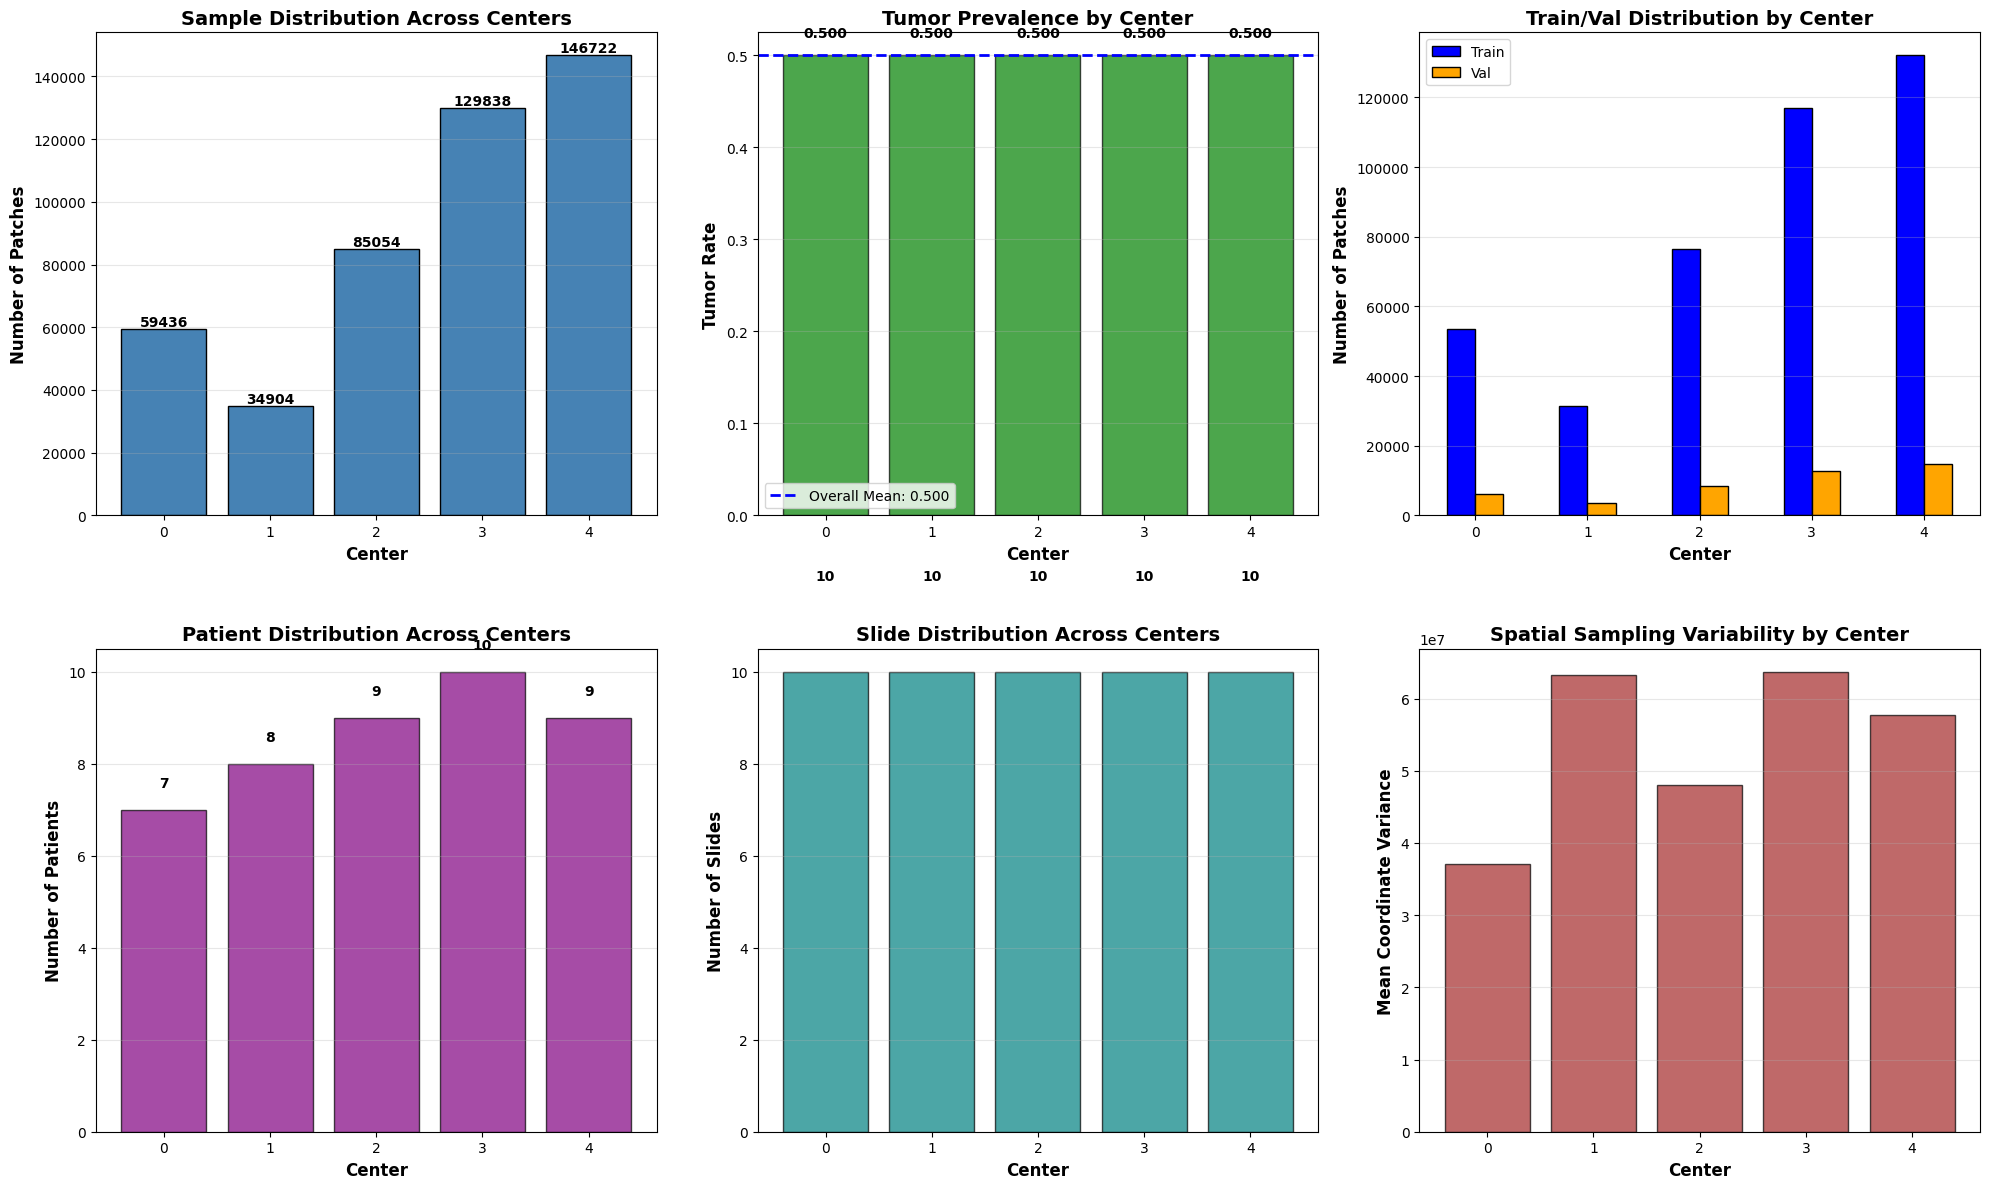


2. STATISTICAL TESTS FOR DOMAIN SHIFT

2.1 Chi-Square Test for Tumor Distribution:
    Chi2 Statistic: 0.0000
    P-value: 1.000000
    Degrees of Freedom: 4
    Result: No significant shift (α=0.05)

2.2 Kolmogorov-Smirnov Tests for Continuous Features:

    Feature: x_coord
      Center 0 vs 1: KS=0.2926, p=0.000000 [SHIFT]
      Center 0 vs 2: KS=0.5271, p=0.000000 [SHIFT]
      Center 0 vs 3: KS=0.1058, p=0.000000 [SHIFT]
      Center 0 vs 4: KS=0.7590, p=0.000000 [SHIFT]
      Center 1 vs 2: KS=0.4695, p=0.000000 [SHIFT]
      Center 1 vs 3: KS=0.3290, p=0.000000 [SHIFT]
      Center 1 vs 4: KS=0.7542, p=0.000000 [SHIFT]
      Center 2 vs 3: KS=0.4452, p=0.000000 [SHIFT]
      Center 2 vs 4: KS=0.3355, p=0.000000 [SHIFT]
      Center 3 vs 4: KS=0.7216, p=0.000000 [SHIFT]

    Feature: y_coord
      Center 0 vs 1: KS=0.1833, p=0.000000 [SHIFT]
      Center 0 vs 2: KS=0.7775, p=0.000000 [SHIFT]
      Center 0 vs 3: KS=0.4245, p=0.000000 [SHIFT]
      Center 0 vs 4: KS=0.8361, p=0.0

Computing predictions per center: 100%|██████████| 45595/45595 [04:17<00:00, 176.83it/s]



  Center  Samples  Accuracy  Precision   Recall  F1-Score  AUC-ROC
      0     6011  0.986691   0.984945 0.988251  0.986595 0.998982
      1     3474  0.973805   0.970588 0.977778  0.974170 0.996834
      2     8561  0.989487   0.994345 0.984601  0.989449 0.999405
      3    12879  0.991304   0.995427 0.987023  0.991207 0.999507
      4    14670  0.988821   0.990971 0.986313  0.988636 0.999555


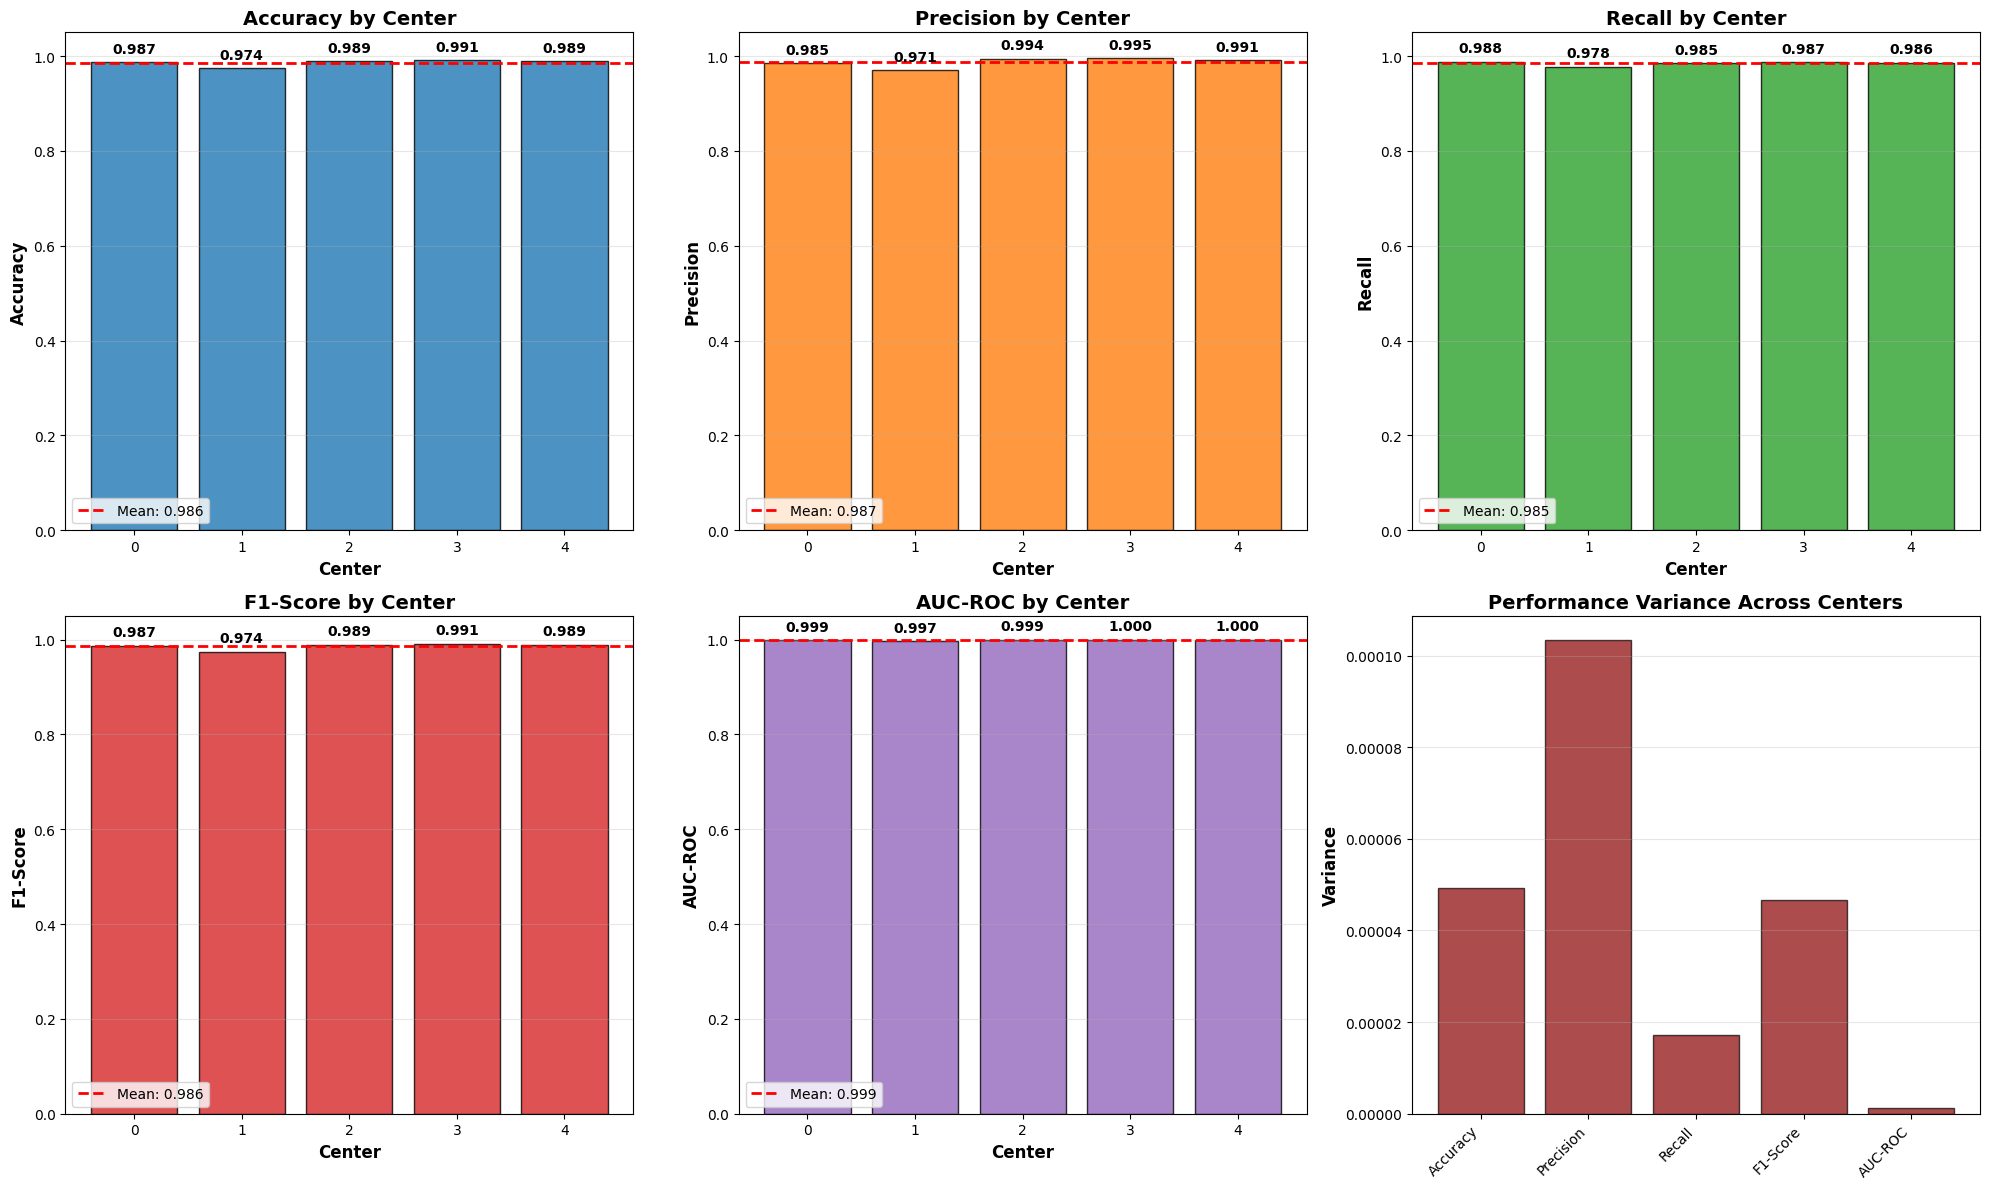


4. FEATURE DISTRIBUTION SHIFTS ACROSS CENTERS


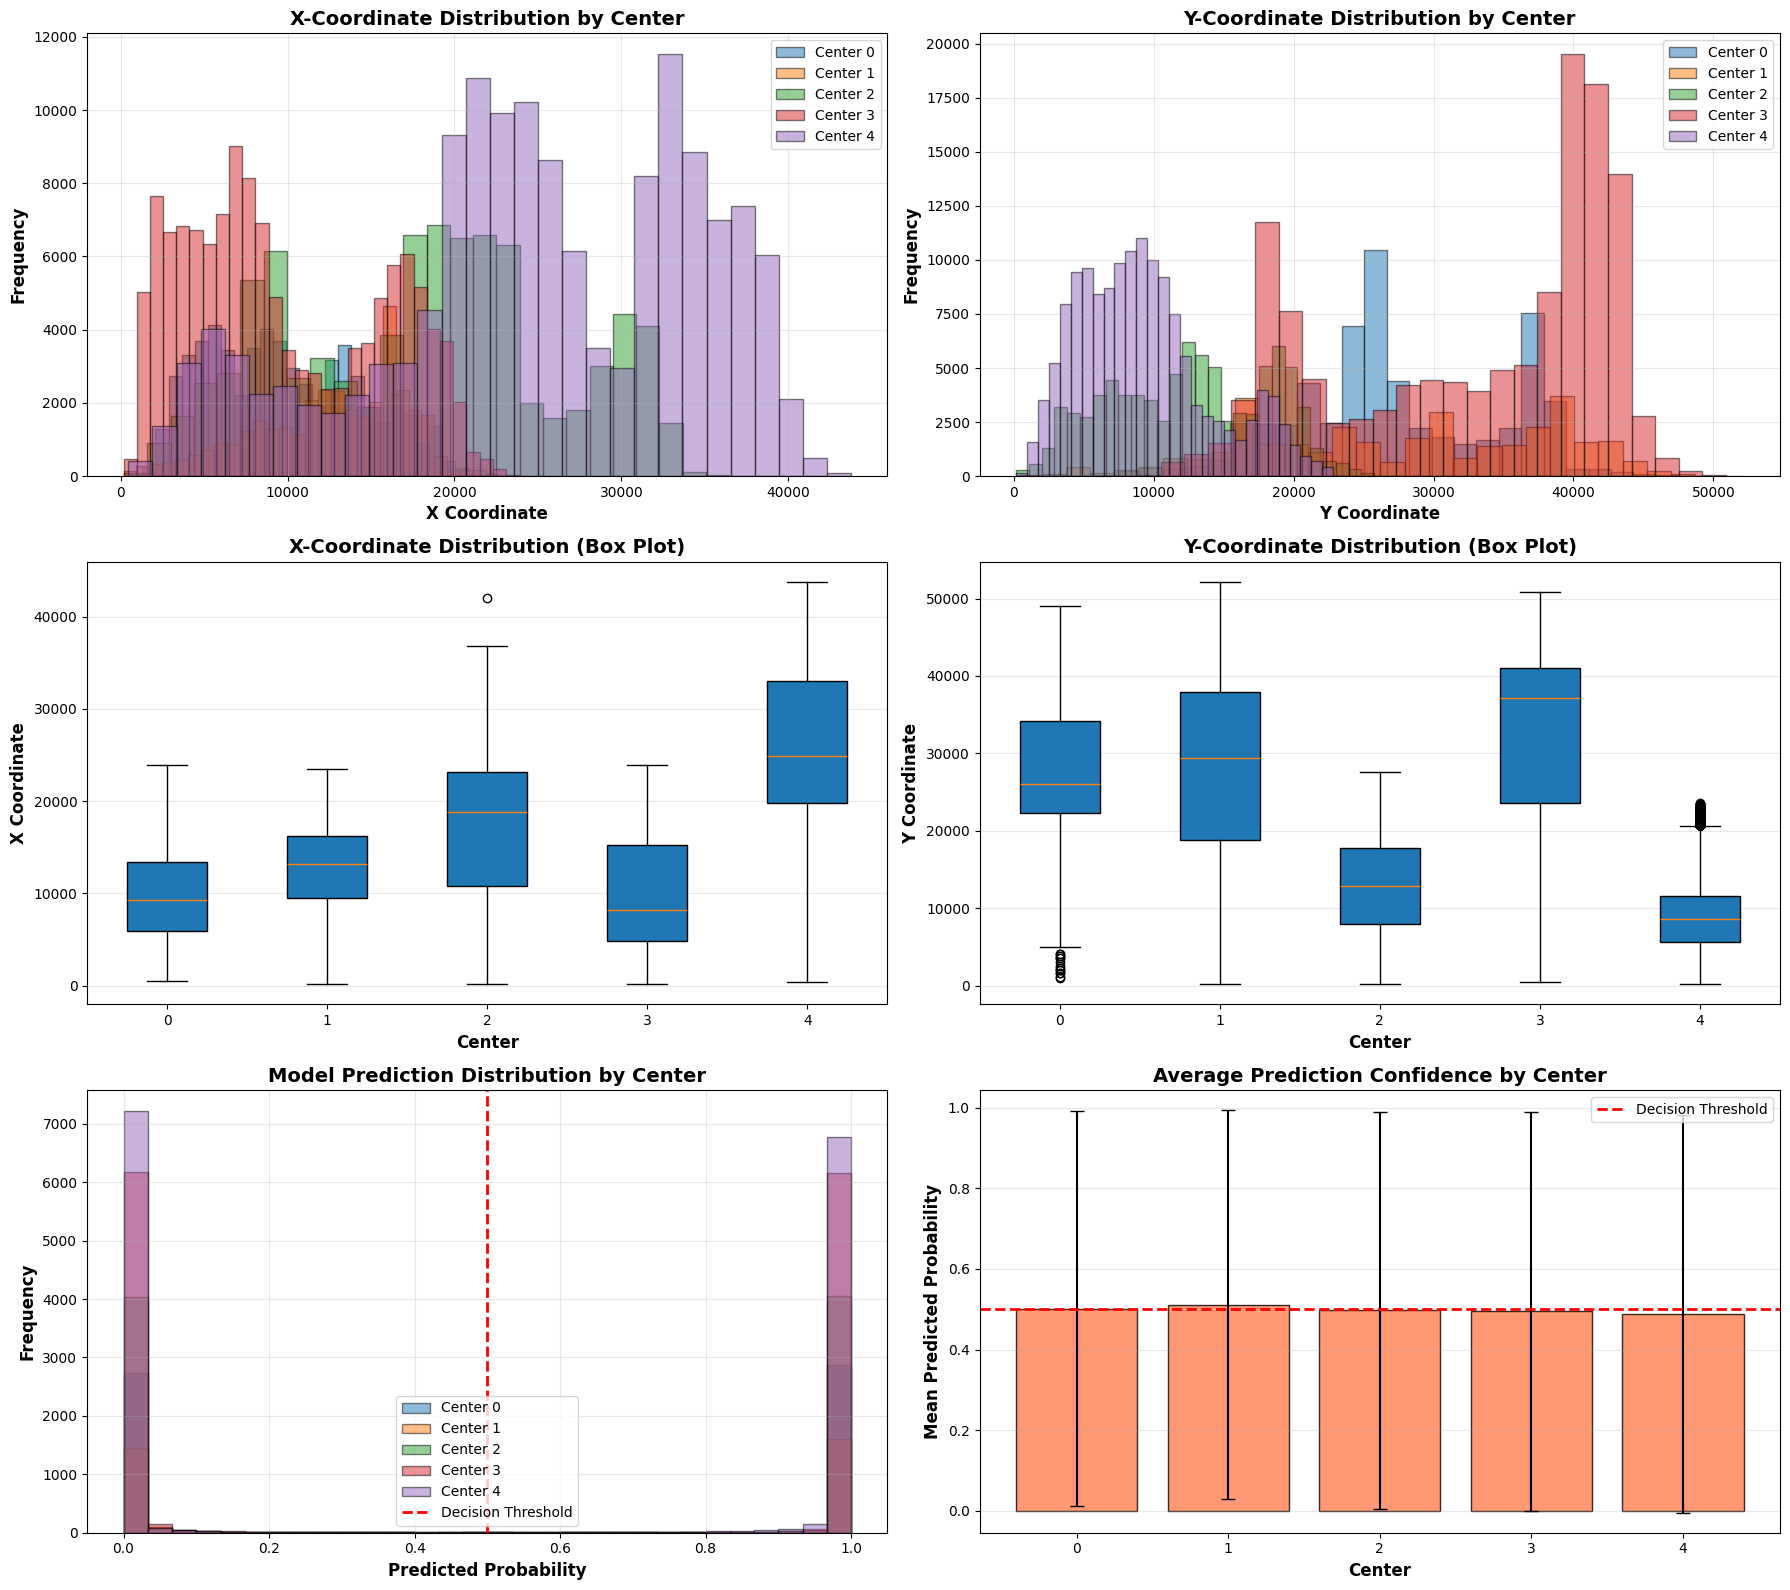


5. EMBEDDING SPACE ANALYSIS (PCA & t-SNE)

Extracting CNN features from validation set...


Extracting features: 100%|██████████| 5000/5000 [00:25<00:00, 195.66it/s]



Performing PCA...
Explained variance ratio: [0.8144165  0.11844718]
Total variance explained: 0.9329

Performing t-SNE (this may take a few minutes)...


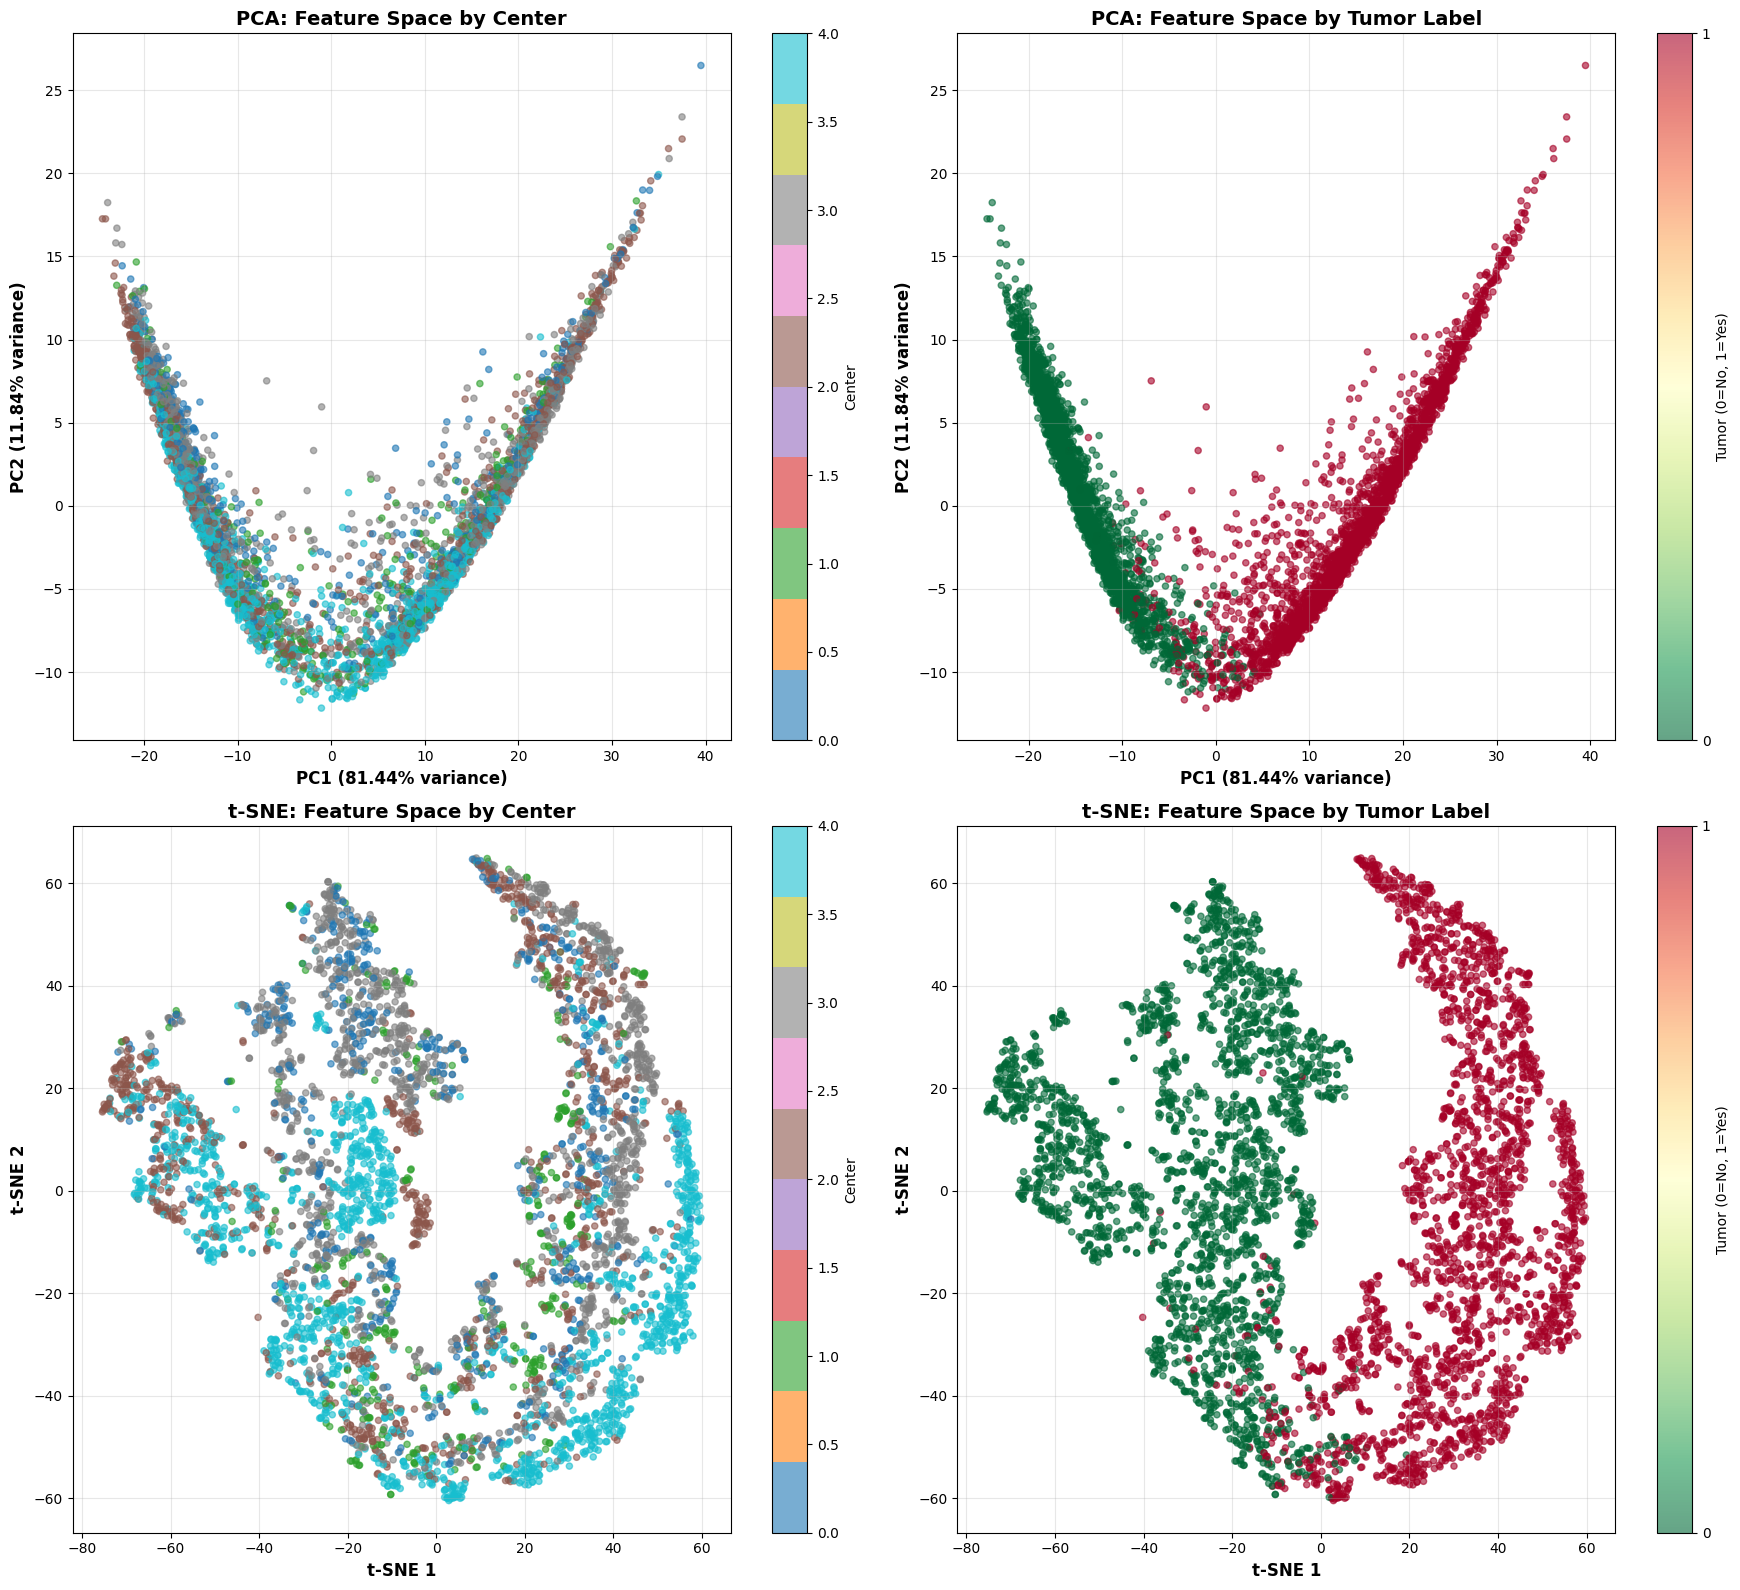


6. DETAILED CONFUSION MATRICES BY CENTER

Center 0:
  TN=2987, FP=45, FN=35, TP=2944
  FPR: 0.0148, FNR: 0.0117

Center 1:
  TN=1667, FP=52, FN=39, TP=1716
  FPR: 0.0303, FNR: 0.0222

Center 2:
  TN=4251, FP=24, FN=66, TP=4220
  FPR: 0.0056, FNR: 0.0154

Center 3:
  TN=6454, FP=29, FN=83, TP=6313
  FPR: 0.0045, FNR: 0.0130

Center 4:
  TN=7372, FP=65, FN=99, TP=7134
  FPR: 0.0087, FNR: 0.0137


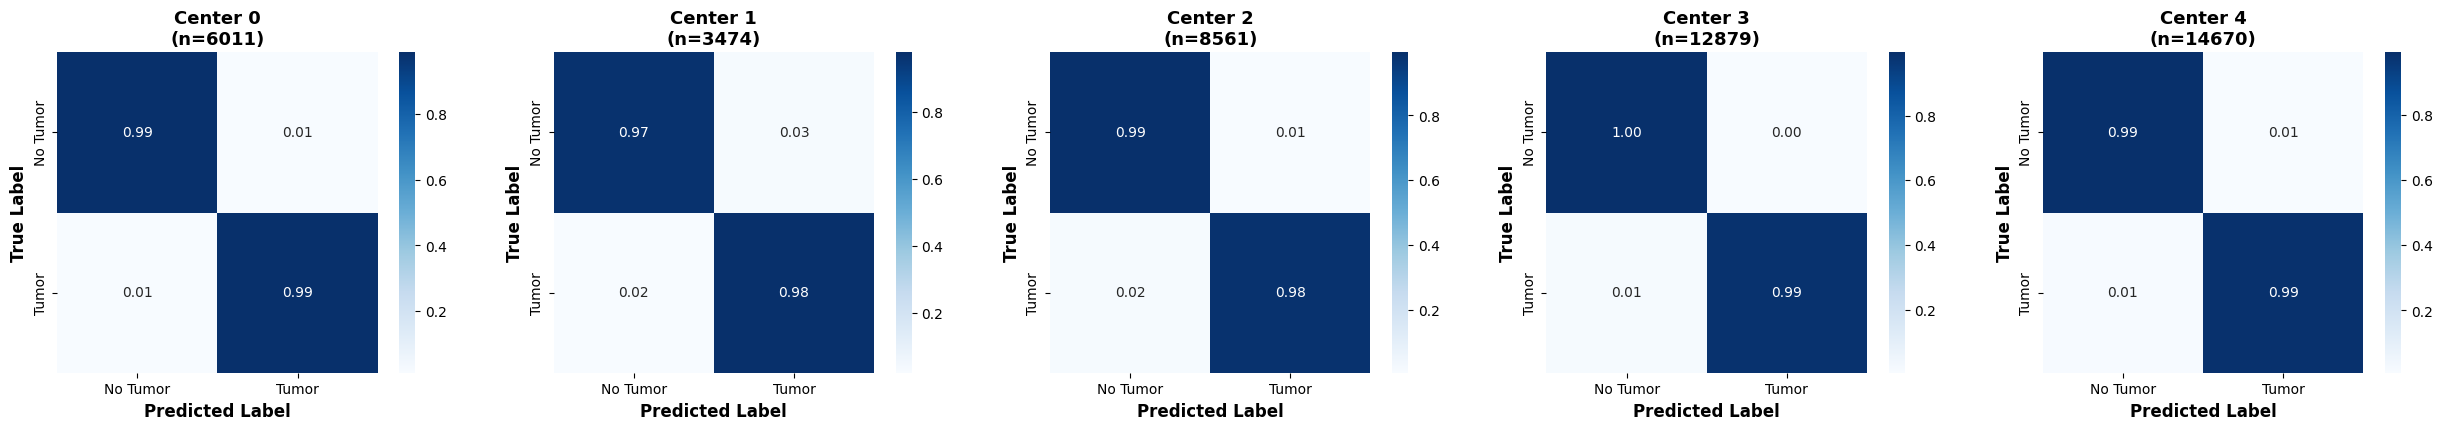


7. DOMAIN SHIFT MAGNITUDE SUMMARY

Performance Variability (Avg Std Dev): 0.0070
Tumor Rate Variability (Std Dev): 0.0000

OVERALL DOMAIN SHIFT ASSESSMENT: LOW

Model shows good generalization across centers.

DOMAIN SHIFT ANALYSIS COMPLETE


In [17]:
# ============================================================================
# COMPREHENSIVE DOMAIN SHIFT ANALYSIS FOR CAMELYON17
# ============================================================================
# Camelyon17 contains data from 5 different medical centers (hospitals)
# Domain shift occurs when the data distribution shifts between centers
# This is critical for medical AI as models must generalize across hospitals
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("CAMELYON17 DOMAIN SHIFT ANALYSIS")
print("="*80)
print("\nAnalyzing distribution shifts across medical centers...")
print("Domains (Centers):", sorted(df['center'].unique()))

# ============================================================================
# 1. DATASET OVERVIEW BY CENTER/DOMAIN
# ============================================================================

print("\n" + "="*80)
print("1. DATASET DISTRIBUTION ACROSS CENTERS")
print("="*80)

center_stats = df.groupby('center').agg({
    'tumor': ['count', 'sum', 'mean'],
    'patient': 'nunique',
    'node': 'nunique',
    'slide': 'nunique'
}).round(4)

center_stats.columns = ['Total_Patches', 'Tumor_Patches', 'Tumor_Rate',
                        'Num_Patients', 'Num_Nodes', 'Num_Slides']

print("\n", center_stats)

# Visualize dataset distribution
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1.1 Sample distribution
center_counts = df['center'].value_counts().sort_index()
axes[0, 0].bar(center_counts.index, center_counts.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Center', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Patches', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Sample Distribution Across Centers', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(center_counts.values):
    axes[0, 0].text(center_counts.index[i], v + 1000, str(v), ha='center', fontweight='bold')

# 1.2 Tumor rate by center
tumor_rates = df.groupby('center')['tumor'].mean()
colors = ['red' if rate > 0.5 else 'green' for rate in tumor_rates.values]
axes[0, 1].bar(tumor_rates.index, tumor_rates.values, color=colors, edgecolor='black', alpha=0.7)
axes[0, 1].axhline(y=df['tumor'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Overall Mean: {df["tumor"].mean():.3f}')
axes[0, 1].set_xlabel('Center', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Tumor Rate', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Tumor Prevalence by Center', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(tumor_rates.values):
    axes[0, 1].text(tumor_rates.index[i], v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# 1.3 Train/Val split by center
split_dist = df.groupby(['center', 'split']).size().unstack(fill_value=0)
split_dist.plot(kind='bar', stacked=False, ax=axes[0, 2], color=['blue', 'orange'], edgecolor='black')
axes[0, 2].set_xlabel('Center', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Number of Patches', fontsize=12, fontweight='bold')
axes[0, 2].set_title('Train/Val Distribution by Center', fontsize=14, fontweight='bold')
axes[0, 2].legend(['Train', 'Val'], fontsize=10)
axes[0, 2].set_xticklabels(axes[0, 2].get_xticklabels(), rotation=0)
axes[0, 2].grid(axis='y', alpha=0.3)

# 1.4 Number of patients per center
patient_counts = df.groupby('center')['patient'].nunique()
axes[1, 0].bar(patient_counts.index, patient_counts.values, color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Center', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Patient Distribution Across Centers', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(patient_counts.values):
    axes[1, 0].text(patient_counts.index[i], v + 0.5, str(v), ha='center', fontweight='bold')

# 1.5 Slides per center
slide_counts = df.groupby('center')['slide'].nunique()
axes[1, 1].bar(slide_counts.index, slide_counts.values, color='teal', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Center', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of Slides', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Slide Distribution Across Centers', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(slide_counts.values):
    axes[1, 1].text(slide_counts.index[i], v + 2, str(v), ha='center', fontweight='bold')

# 1.6 Spatial distribution (x_coord, y_coord variance)
spatial_var = df.groupby('center')[['x_coord', 'y_coord']].var().mean(axis=1)
axes[1, 2].bar(spatial_var.index, spatial_var.values, color='brown', edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('Center', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Mean Coordinate Variance', fontsize=12, fontweight='bold')
axes[1, 2].set_title('Spatial Sampling Variability by Center', fontsize=14, fontweight='bold')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 2. STATISTICAL TESTS FOR DISTRIBUTION SHIFTS
# ============================================================================

print("\n" + "="*80)
print("2. STATISTICAL TESTS FOR DOMAIN SHIFT")
print("="*80)

# 2.1 Chi-square test for tumor label distribution
contingency_table = pd.crosstab(df['center'], df['tumor'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\n2.1 Chi-Square Test for Tumor Distribution:")
print(f"    Chi2 Statistic: {chi2:.4f}")
print(f"    P-value: {p_value:.6f}")
print(f"    Degrees of Freedom: {dof}")
print(f"    Result: {'SIGNIFICANT SHIFT' if p_value < 0.05 else 'No significant shift'} (α=0.05)")

# 2.2 Kolmogorov-Smirnov tests for continuous features
print(f"\n2.2 Kolmogorov-Smirnov Tests for Continuous Features:")
centers = sorted(df['center'].unique())
for feature in ['x_coord', 'y_coord']:
    print(f"\n    Feature: {feature}")
    for i in range(len(centers)):
        for j in range(i+1, len(centers)):
            center_i_data = df[df['center'] == centers[i]][feature]
            center_j_data = df[df['center'] == centers[j]][feature]
            ks_stat, ks_pval = ks_2samp(center_i_data, center_j_data)
            shift_status = "SHIFT" if ks_pval < 0.05 else "No shift"
            print(f"      Center {centers[i]} vs {centers[j]}: KS={ks_stat:.4f}, p={ks_pval:.6f} [{shift_status}]")

# ============================================================================
# 3. MODEL PERFORMANCE ACROSS DOMAINS
# ============================================================================

print("\n" + "="*80)
print("3. MODEL PERFORMANCE BREAKDOWN BY CENTER (Validation Set)")
print("="*80)

# Get predictions per center
val_df_with_preds = val_df.copy()
center_preds = {center: [] for center in val_df['center'].unique()}
center_labels = {center: [] for center in val_df['center'].unique()}
center_probs = {center: [] for center in val_df['center'].unique()}

model.eval()
with torch.no_grad():
    for idx in tqdm(range(len(val_df)), desc="Computing predictions per center"):
        row = val_df.iloc[idx]
        img = Image.open(row.img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)
        cat_tensor = torch.tensor([int(row[col]) for col in cat_cols_encoded], dtype=torch.long).unsqueeze(0).to(device)
        cont_tensor = torch.tensor(val_cont[idx], dtype=torch.float32).unsqueeze(0).to(device)

        logits = model(img_tensor, cat_tensor, cont_tensor)
        prob = torch.sigmoid(logits).item()
        pred = 1 if prob > 0.5 else 0

        center = row['center']
        center_preds[center].append(pred)
        center_labels[center].append(row['tumor'])
        center_probs[center].append(prob)

# Calculate metrics per center
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

performance_data = []
for center in sorted(center_preds.keys()):
    preds = np.array(center_preds[center])
    labels = np.array(center_labels[center])
    probs = np.array(center_probs[center])

    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, zero_division=0)
    rec = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)

    # Handle edge case where all labels are same class
    if len(np.unique(labels)) > 1:
        auc = roc_auc_score(labels, probs)
    else:
        auc = np.nan

    performance_data.append({
        'Center': center,
        'Samples': len(labels),
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC-ROC': auc
    })

perf_df = pd.DataFrame(performance_data)
print("\n", perf_df.to_string(index=False))

# Visualize performance metrics
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
colors_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    values = perf_df[metric].values
    centers_list = perf_df['Center'].values

    bars = ax.bar(centers_list, values, color=colors_palette[idx], edgecolor='black', alpha=0.8)

    # Add overall mean line
    overall_mean = np.nanmean(values)
    ax.axhline(y=overall_mean, color='red', linestyle='--', linewidth=2,
               label=f'Mean: {overall_mean:.3f}')

    ax.set_xlabel('Center', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} by Center', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.05])

    # Add value labels
    for i, (center, val) in enumerate(zip(centers_list, values)):
        if not np.isnan(val):
            ax.text(center, val + 0.02, f'{val:.3f}', ha='center', fontweight='bold', fontsize=10)

# Performance variance analysis
ax = axes[1, 2]
metric_variance = perf_df[metrics].var()
ax.bar(range(len(metrics)), metric_variance.values, color='darkred', edgecolor='black', alpha=0.7)
ax.set_xticks(range(len(metrics)))
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.set_ylabel('Variance', fontsize=12, fontweight='bold')
ax.set_title('Performance Variance Across Centers', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 4. FEATURE DISTRIBUTION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("4. FEATURE DISTRIBUTION SHIFTS ACROSS CENTERS")
print("="*80)

fig, axes = plt.subplots(3, 2, figsize=(18, 16))

# 4.1 X-coordinate distribution
for center in sorted(df['center'].unique()):
    data = df[df['center'] == center]['x_coord']
    axes[0, 0].hist(data, bins=30, alpha=0.5, label=f'Center {center}', edgecolor='black')
axes[0, 0].set_xlabel('X Coordinate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 0].set_title('X-Coordinate Distribution by Center', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 4.2 Y-coordinate distribution
for center in sorted(df['center'].unique()):
    data = df[df['center'] == center]['y_coord']
    axes[0, 1].hist(data, bins=30, alpha=0.5, label=f'Center {center}', edgecolor='black')
axes[0, 1].set_xlabel('Y Coordinate', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Y-Coordinate Distribution by Center', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 4.3 Box plots for coordinates
coord_data = []
for center in sorted(df['center'].unique()):
    coord_data.append(df[df['center'] == center]['x_coord'].values)
axes[1, 0].boxplot(coord_data, labels=sorted(df['center'].unique()), patch_artist=True)
axes[1, 0].set_xlabel('Center', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('X Coordinate', fontsize=12, fontweight='bold')
axes[1, 0].set_title('X-Coordinate Distribution (Box Plot)', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

coord_data_y = []
for center in sorted(df['center'].unique()):
    coord_data_y.append(df[df['center'] == center]['y_coord'].values)
axes[1, 1].boxplot(coord_data_y, labels=sorted(df['center'].unique()), patch_artist=True)
axes[1, 1].set_xlabel('Center', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Y Coordinate', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Y-Coordinate Distribution (Box Plot)', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# 4.4 Prediction probability distribution by center
for center in sorted(center_probs.keys()):
    probs = center_probs[center]
    axes[2, 0].hist(probs, bins=30, alpha=0.5, label=f'Center {center}', edgecolor='black')
axes[2, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
axes[2, 0].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[2, 0].set_title('Model Prediction Distribution by Center', fontsize=14, fontweight='bold')
axes[2, 0].legend()
axes[2, 0].grid(alpha=0.3)

# 4.5 Mean prediction probability by center
mean_probs = [np.mean(center_probs[c]) for c in sorted(center_probs.keys())]
std_probs = [np.std(center_probs[c]) for c in sorted(center_probs.keys())]
centers_sorted = sorted(center_probs.keys())
axes[2, 1].bar(centers_sorted, mean_probs, yerr=std_probs, capsize=5,
               color='coral', edgecolor='black', alpha=0.8)
axes[2, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
axes[2, 1].set_xlabel('Center', fontsize=12, fontweight='bold')
axes[2, 1].set_ylabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
axes[2, 1].set_title('Average Prediction Confidence by Center', fontsize=14, fontweight='bold')
axes[2, 1].legend()
axes[2, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 5. DIMENSIONALITY REDUCTION & VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("5. EMBEDDING SPACE ANALYSIS (PCA & t-SNE)")
print("="*80)

# Sample data for visualization (too much data for t-SNE)
sample_size = 5000
if len(val_df) > sample_size:
    sample_indices = np.random.choice(len(val_df), sample_size, replace=False)
else:
    sample_indices = np.arange(len(val_df))

# Extract features from model
print("\nExtracting CNN features from validation set...")
features_list = []
centers_list = []
labels_list = []

model.eval()
with torch.no_grad():
    for idx in tqdm(sample_indices, desc="Extracting features"):
        row = val_df.iloc[idx]
        img = Image.open(row.img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Extract CNN features
        cnn_features = model.cnn(img_tensor).cpu().numpy().flatten()
        features_list.append(cnn_features)
        centers_list.append(row['center'])
        labels_list.append(row['tumor'])

features_array = np.array(features_list)
centers_array = np.array(centers_list)
labels_array = np.array(labels_list)

# PCA
print("\nPerforming PCA...")
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_array)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

# t-SNE
print("\nPerforming t-SNE (this may take a few minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_result = tsne.fit_transform(features_array)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# 5.1 PCA - colored by center
scatter1 = axes[0, 0].scatter(pca_result[:, 0], pca_result[:, 1],
                               c=centers_array, cmap='tab10', alpha=0.6, s=20)
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('PCA: Feature Space by Center', fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0, 0], label='Center')
axes[0, 0].grid(alpha=0.3)

# 5.2 PCA - colored by tumor label
scatter2 = axes[0, 1].scatter(pca_result[:, 0], pca_result[:, 1],
                               c=labels_array, cmap='RdYlGn_r', alpha=0.6, s=20)
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('PCA: Feature Space by Tumor Label', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[0, 1], label='Tumor (0=No, 1=Yes)', ticks=[0, 1])
axes[0, 1].grid(alpha=0.3)

# 5.3 t-SNE - colored by center
scatter3 = axes[1, 0].scatter(tsne_result[:, 0], tsne_result[:, 1],
                               c=centers_array, cmap='tab10', alpha=0.6, s=20)
axes[1, 0].set_xlabel('t-SNE 1', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('t-SNE 2', fontsize=12, fontweight='bold')
axes[1, 0].set_title('t-SNE: Feature Space by Center', fontsize=14, fontweight='bold')
plt.colorbar(scatter3, ax=axes[1, 0], label='Center')
axes[1, 0].grid(alpha=0.3)

# 5.4 t-SNE - colored by tumor label
scatter4 = axes[1, 1].scatter(tsne_result[:, 0], tsne_result[:, 1],
                               c=labels_array, cmap='RdYlGn_r', alpha=0.6, s=20)
axes[1, 1].set_xlabel('t-SNE 1', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('t-SNE 2', fontsize=12, fontweight='bold')
axes[1, 1].set_title('t-SNE: Feature Space by Tumor Label', fontsize=14, fontweight='bold')
plt.colorbar(scatter4, ax=axes[1, 1], label='Tumor (0=No, 1=Yes)', ticks=[0, 1])
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 6. CONFUSION MATRIX PER CENTER
# ============================================================================

print("\n" + "="*80)
print("6. DETAILED CONFUSION MATRICES BY CENTER")
print("="*80)

from sklearn.metrics import confusion_matrix

n_centers = len(center_preds)
fig, axes = plt.subplots(1, n_centers, figsize=(5*n_centers, 4))
if n_centers == 1:
    axes = [axes]

for idx, center in enumerate(sorted(center_preds.keys())):
    cm = confusion_matrix(center_labels[center], center_preds[center])

    # Normalize
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                ax=axes[idx], cbar=True, square=True,
                xticklabels=['No Tumor', 'Tumor'],
                yticklabels=['No Tumor', 'Tumor'])

    axes[idx].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'Center {center}\n(n={len(center_labels[center])})',
                        fontsize=13, fontweight='bold')

    # Print raw counts
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    print(f"\nCenter {center}:")
    print(f"  TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print(f"  FPR: {fp/(fp+tn):.4f}, FNR: {fn/(fn+tp):.4f}" if (fp+tn)>0 and (fn+tp)>0 else "")

plt.tight_layout()
plt.show()

# ============================================================================
# 7. SHIFT MAGNITUDE SUMMARY
# ============================================================================

print("\n" + "="*80)
print("7. DOMAIN SHIFT MAGNITUDE SUMMARY")
print("="*80)

# Calculate shift scores
performance_std = perf_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].std().mean()
tumor_rate_std = df.groupby('center')['tumor'].mean().std()

print(f"\nPerformance Variability (Avg Std Dev): {performance_std:.4f}")
print(f"Tumor Rate Variability (Std Dev): {tumor_rate_std:.4f}")

# Overall shift assessment
if performance_std > 0.1:
    shift_level = "HIGH"
elif performance_std > 0.05:
    shift_level = "MODERATE"
else:
    shift_level = "LOW"

print(f"\n{'='*80}")
print(f"OVERALL DOMAIN SHIFT ASSESSMENT: {shift_level}")
print(f"{'='*80}")

if shift_level == "HIGH":
    print("\nRECOMMENDATIONS:")
    print("  - Consider domain adaptation techniques (e.g., adversarial training)")
    print("  - Use domain-specific fine-tuning")
    print("  - Implement domain-invariant feature learning")
    print("  - Consider test-time adaptation strategies")
elif shift_level == "MODERATE":
    print("\nRECOMMENDATIONS:")
    print("  - Monitor performance on new centers carefully")
    print("  - Consider ensemble methods combining domain-specific models")
    print("  - Apply normalization/calibration techniques")
else:
    print("\nModel shows good generalization across centers.")

print("\n" + "="*80)
print("DOMAIN SHIFT ANALYSIS COMPLETE")
print("="*80)